# Writing Fluid Simulations in Φ<sub>Flow</sub>

[![Google Collab Book](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tum-pbs/PhiFlow/blob/develop/docs/Fluid_Simulation.ipynb)

There are two main viewpoints for simulating fluids:

* *Eulerian* simulations use grids, tracking fluid distribution and fluid velocity at fixed sample points
* *Lagrangian* simulations track particles that move with the fluid.

Φ<sub>Flow</sub> supports both methods to some extent but mainly focuses on Eulerian simulations.

Before we discuss the various operations required for fluid simulations, let's define our variables and initial state.
In this case, we will create a 64×96 grid, sampling velocity vectors [in staggered form](Staggered_Grids.html) and marker values at the centroids.

In [ ]:
!pip install phiflow

<Figure size 864x360 with 3 Axes>

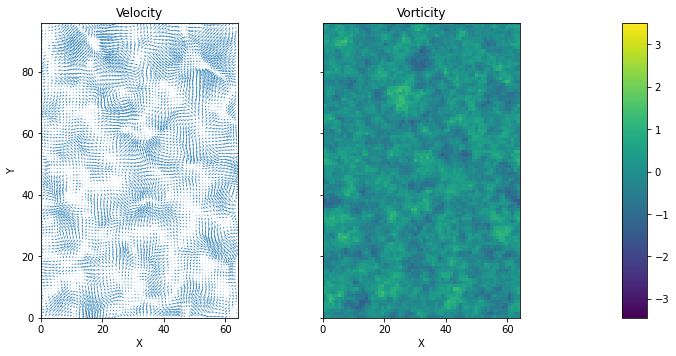

In [12]:
from tqdm.notebook import trange
from phi.jax.flow import *  # imports sub-modules + core classes

velocity = StaggeredGrid(Noise(), 'periodic', x=64, y=96)
plot({"velocity": velocity, "vorticity": field.curl(velocity)})

## Operator Splitting

The Navier-Stokes equations for fluids, $\frac{\partial u}{\partial t} = - (u \cdot \nabla) u - \nu \nabla^2 u - \frac 1 \rho \nabla p + g$, comprise multiple terms.

Operator splitting enables writing fast and stable fluid simulations by sequentially evaluating the different terms.
For each of the terms, Φ<sub>Flow</sub> provides functions to compute them:

* Advection: [`advect.semi_lagrangian`](https://tum-pbs.github.io/PhiFlow/phi/physics/advect.html#phi.physics.advect.semi_lagrangian) \[Stam 1999\], [`advect.mac_cormack`](https://tum-pbs.github.io/PhiFlow/phi/physics/advect.html#phi.physics.advect.mac_cormack) \[MacCormack 2002\]
* Diffusion: [`diffuse.explicit`](https://tum-pbs.github.io/PhiFlow/phi/physics/diffuse.html#phi.physics.diffuse.explicit), [`diffuse.implicit`](https://tum-pbs.github.io/PhiFlow/phi/physics/diffuse.html#phi.physics.diffuse.implicit)
* Pressure projection: [`fluid.make_incompressible`](https://tum-pbs.github.io/PhiFlow/phi/physics/fluid.html#phi.physics.fluid.make_incompressible) \[Chorin and Temam 1968\]

All of these functions take in a state variable and return the new state after a certain time `dt` has passed.
In the following example, the velocity is self-advected and made incompressible, while the marker is passively advected.

<Figure size 864x360 with 4 Axes>

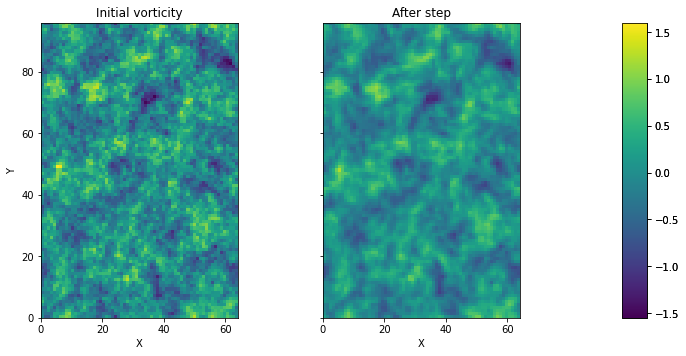

In [11]:
@jit_compile
def operator_split_step(v, p, dt):
    v = advect.semi_lagrangian(v, v, dt)  # velocity self-advection
    v = diffuse.explicit(v, 0.1, dt)
    v, p = fluid.make_incompressible(v, (), Solve(x0=p))
    return v, p

velocity0, pressure0 = fluid.make_incompressible(velocity)
velocity1, pressure1 = operator_split_step(velocity0, None, dt=1.)
plot({'initial vorticity': field.curl(velocity0), 'after step': field.curl(velocity1)})

We can use [`iterate`](https://tum-pbs.github.io/PhiML/phiml/math/index.html#phiml.math.iterate) to compute a trajectory by repeatedly calling `operator_split_step`.
All intermediate states are stacked along the specified dimension which we call `time`.

In [13]:
velocity_trj, pressure_trj = iterate(operator_split_step, batch(time=100), velocity0, pressure0, dt=1., range=trange)

  0%|          | 0/100 [00:00<?, ?it/s]

Alternatively, we could have written a `for` loop, added all intermediate states to a list, and stacked the results afterward.
Now, let's plot this trajectory by animating the `time` dimension.

In [14]:
plot(field.curl(velocity_trj), animate='time', same_scale=False)

## Higher-Order Simulations

The operator splitting approach is not compatible with more accurate numerical schemes.
For more accurate simulations, we can use higher-order spatial schemes as well as time integration.
In that case, we define a momentum equation which computes the PDE terms directly, without integrating them in time.
The following example computes explicit fourth-order accurate advection and diffusion.

In [15]:
def momentum_equation(v, viscosity=0.1):
    advection = advect.finite_difference(v, v, order=4, implicit=None)
    diffusion = diffuse.finite_difference(v, viscosity, order=4, implicit=None)
    return advection + diffusion

Next, we perform time integration with the incompressibility constraint.
This is considerably more expensive than the previous approach but yields much more accurate results.

In [16]:
@jit_compile
def rk4_step(v, p, dt):
    return fluid.incompressible_rk4(momentum_equation, v, p, dt, pressure_order=4)

velocity_trj, pressure_trj = iterate(rk4_step, batch(time=200), velocity0, pressure0, dt=.5, range=trange)
plot(field.curl(velocity_trj.time[::2]), animate='time', same_scale=False)

  0%|          | 0/200 [00:00<?, ?it/s]

## Further Reading

The [Kolmogorov flow notebebook](prerendered/HigherOrder_Demo.ipynb) shows higher-order fluid flow with forcing.

For a comparison of various schemes in both accuracy and performance is given [here](prerendered/Taylor_Green_Comparison.ipynb).

Coupling between centered and staggered fields can be seen in the [smoke plume notebook](https://tum-pbs.github.io/PhiFlow/Fluids_Tutorial.html) and [Python script](https://github.com/tum-pbs/PhiFlow/blob/master/demos/smoke_plume.py).